# RDKit workshop

In the following, RDKit will be applied to explore a chemical dataset (Delaney) on the solubility of various substances in water (logS(mol/L)).

### Part 1: Data loading and exploration

Inspect the dataset and visualise the solubility distribution (EDA). Tasks:
- How many compounds are in the dataset?
- What is the average and range of the solubility values in the dataset?
- Are there extreme outliers (e.g. box plot)?

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("delaney.csv")
df

,Compound ID,logS,SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...
1139,vamidothion,1.144,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


In [2]:
df.shape

(1144, 3)

In [3]:
df.describe()

,logS
count,1144.000000
mean,-3.057997
std,2.096502
min,-11.600000
25%,-4.332250
50%,-2.870500
75%,-1.600000
max,1.580000


In [ ]:
df.info()

In [4]:
df["Compound ID"].nunique()

1143

In [5]:
df["SMILES"].nunique()

1128

In [6]:
df["Compound ID"].duplicated().sum()

np.int64(1)

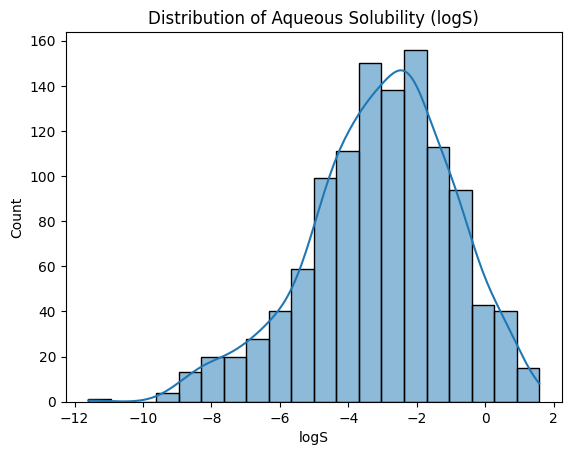

In [7]:

sns.histplot(df['logS'], bins=20, kde=True)
plt.title("Distribution of Aqueous Solubility (logS)")
plt.show()

<Axes: >

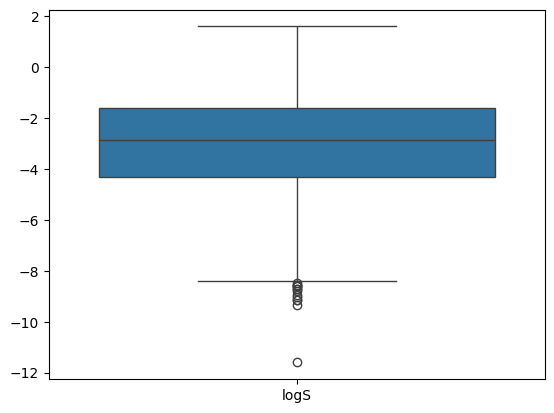

In [8]:
sns.boxplot(df)

### Part 2: Compute descriptors with RDKit

Calculate molecular descriptors from the SMILES. See snippet below for the syntax of doing so.

Tasks:
- Compute 5-10 descriptors based on the SMILES (e.g. use the apply() method in pandas) and add them to the DataFrame
- Find out if there is any correlation of the descriptors and the solubility (e.g. plots)

Some info on available descriptors: 
- https://github.com/hypowergravity/RDKitDescriptorExamples-
- https://schwallergroup.github.io/practical-programming-in-chemistry/tutorials/lecture_05/02_rdkit_descriptors.html
- https://deepwiki.com/rdkit/rdkit/6.1-chemical-reactions#molecular-descriptors-and-properties

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors

# Syntax for deriving descriptors:
# 1) convert smiles to Mol: mol = Chem.MolFromSmiles(smiles)
# 2) derive descriptor, e.g. for MolWt: descr = Descriptors.MolWt(mol)
def calculate_descriptors(smiles):
    mol= Chem.MolFromSmiles(smiles)
    return Descriptors.MolWt(mol)
# for descr in descr_list:
#     df[descr] = df["SMILES"].apply(lambda s: calc_descriptors(s, descr))

df["MolWt"] = df["SMILES"].apply(lambda s: Descriptors.MolWt(Chem.MolFromSmiles(s)))
df["TPSA"] = df["SMILES"].apply(lambda s: Descriptors.TPSA(Chem.MolFromSmiles(s)))
df["BalabanJ"] = df["SMILES"].apply(lambda s: Descriptors.BalabanJ(Chem.MolFromSmiles(s)))
df["NumHAcceptors"] = df["SMILES"].apply(lambda s: Descriptors.NumHAcceptors(Chem.MolFromSmiles(s)))
df["MolLogP"] = df["SMILES"].apply(lambda s: Descriptors.MolLogP(Chem.MolFromSmiles(s)))
df["NumHeteroatoms"] = df["SMILES"].apply(lambda s: Descriptors.NumHeteroatoms(Chem.MolFromSmiles(s)))
df["SPS"] = df["SMILES"].apply(lambda s: Descriptors.SPS(Chem.MolFromSmiles(s)))
df["Phi"] = df["SMILES"].apply(lambda s: Descriptors.Phi(Chem.MolFromSmiles(s)))
df.head()

,Compound ID,logS,SMILES,MolWt,TPSA,BalabanJ,NumHAcceptors,MolLogP
0,"1,1,1,2-Tetrachloroethane",-2.18,ClCC(Cl)(Cl)Cl,167.850,0.0,3.168490,0,2.5954
1,"1,1,1-Trichloroethane",-2.00,CC(Cl)(Cl)Cl,133.405,0.0,3.023716,0,2.3765
2,"1,1,2,2-Tetrachloroethane",-1.74,ClC(Cl)C(Cl)Cl,167.850,0.0,2.993497,0,2.5938
3,"1,1,2-Trichloroethane",-1.48,ClCC(Cl)Cl,133.405,0.0,2.539539,0,2.0289
4,"1,1,2-Trichlorotrifluoroethane",-3.04,FC(F)(Cl)C(F)(Cl)Cl,187.375,0.0,4.020392,0,2.9189


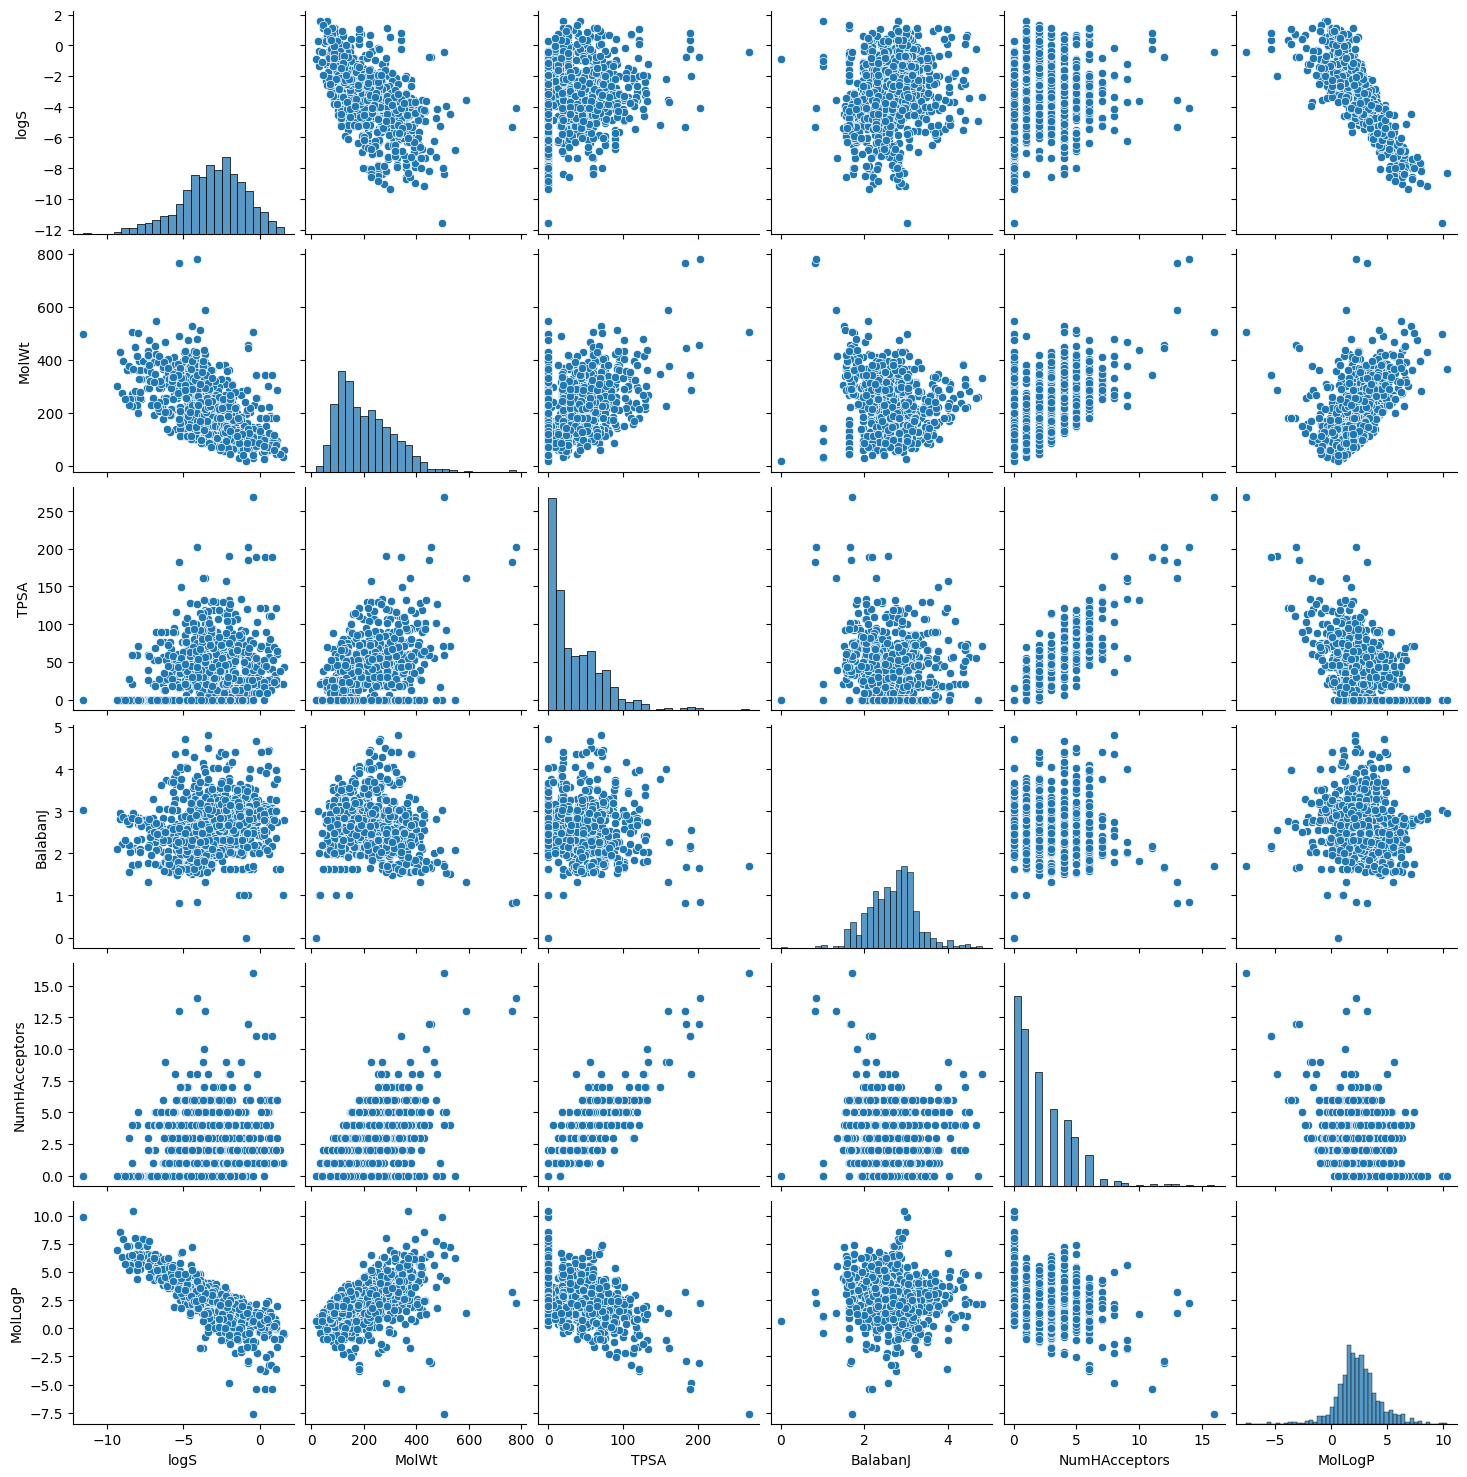

In [10]:
sns.pairplot(df)
plt.show()

### Part 3: Predict solubility (Regression Model)

Use the code below to predict the logS using a RandomForestRegressor:

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

X = df.drop(columns=["logS", "Compound ID", "SMILES"], axis=1)
y = df["logS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=200, random_state=42) #n_estimators is hyperparameters
model.fit(X_train, y_train)
pred = model.predict(X_test)

print("R²:", r2_score(y_test, pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred)))
print("train accuracy:", model.score(X_train, y_train))
print("test accuracy:", model.score(X_test, y_test))


R²: 0.898336713901813
RMSE: 0.6653548702961839
train accuracy: 0.982567343036612
test accuracy: 0.898336713901813


Based on the EDA, which descriptors might influence the solubility the most?

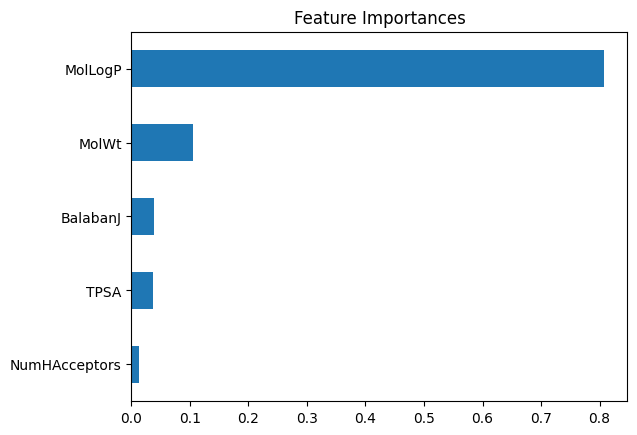

In [12]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importances")
plt.show()

### Part 4: Similarity Search

Create fingerprints from the SMILES and add them to the dataframe.

In [13]:
from rdkit.Chem import rdFingerprintGenerator, DataStructs

# use e.g. the morgan FPG: mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
def mol2_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
    fp = mfpgen.GetFingerprint(mol)
    return fp
df["morganfp"] = df["SMILES"].apply(mol2_fp)

['ClCC(Cl)(Cl)Cl',
 'CC(Cl)(Cl)Cl',
 'ClC(Cl)C(Cl)Cl',
 'ClCC(Cl)Cl',
 'FC(F)(Cl)C(F)(Cl)Cl',
 'CC(Cl)Cl',
 'ClC(=C)Cl',
 'CCOC(C)OCC',
 'Clc1ccc(Cl)c(Cl)c1Cl',
 'C1CCc2ccccc2C1',
 'Clc1cc(Cl)c(Cl)c(Cl)c1',
 'Clc1cccc(Cl)c1Cl',
 'Cc1cccc(C)c1C',
 'Brc1cc(Br)c(Br)cc1Br',
 'Clc1cc(Cl)c(Cl)cc1Cl',
 'Cc1cc(C)c(C)cc1C',
 'c1(Br)c(Br)cc(Br)cc1',
 'Clc1ccc(Cl)c(Cl)c1',
 'Cc1ccc(C)c(C)c1',
 'Oc1ccccc1O',
 'Brc1ccccc1Br',
 'BrCCBr',
 'Clc1ccccc1Cl',
 'ClCCCl',
 'CC(Cl)CCl',
 'FC(F)(Cl)C(F)(F)Cl',
 'CCOCCOCC',
 'CCc1ccccc1CC',
 'O=N(=O)c1ccccc1N(=O)=O',
 'CC1CO1',
 'Brc1cc(Br)cc(Br)c1',
 'Clc1cc(Cl)cc(Cl)c1',
 'Cc1cc(C)cc(C)c1',
 'O=N(=O)c1cc(cc(c1)N(=O)=O)N(=O)=O',
 'Oc1cccc(O)c1',
 'C=CC=C',
 'Brc1cccc(Br)c1',
 'Clc1cccc(Cl)c1',
 'ClCCCCl',
 'CCNC(=S)NCC',
 'Fc1cccc(F)c1',
 'Cc1cc(C)c2ccccc2c1',
 'O=N(=O)c1cccc(c1)N(=O)=O',
 'Oc1ccc(O)cc1',
 'C1C=CCC=C1',
 'Brc1ccc(Br)cc1',
 'Clc1ccc(Cl)cc1',
 'CCc1ccc(CC)cc1',
 'Fc1ccc(F)cc1',
 'Cc1ccc(C)c2ccccc12',
 'O=N(=O)c1ccc(cc1)N(=O)=O',
 'C=CCC=C',
 '

In [14]:
df.head()

,Compound ID,logS,SMILES,MolWt,TPSA,BalabanJ,NumHAcceptors,MolLogP,morganfp
0,"1,1,1,2-Tetrachloroethane",-2.18,ClCC(Cl)(Cl)Cl,167.850,0.0,3.168490,0,2.5954,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"1,1,1-Trichloroethane",-2.00,CC(Cl)(Cl)Cl,133.405,0.0,3.023716,0,2.3765,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"1,1,2,2-Tetrachloroethane",-1.74,ClC(Cl)C(Cl)Cl,167.850,0.0,2.993497,0,2.5938,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"1,1,2-Trichloroethane",-1.48,ClCC(Cl)Cl,133.405,0.0,2.539539,0,2.0289,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"1,1,2-Trichlorotrifluoroethane",-3.04,FC(F)(Cl)C(F)(Cl)Cl,187.375,0.0,4.020392,0,2.9189,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [15]:
df.describe()

,logS,MolWt,TPSA,BalabanJ,NumHAcceptors,MolLogP
count,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000
mean,-3.057997,204.631675,35.058829,2.675403,2.116259,2.449133
std,2.096502,102.620500,35.694546,0.572049,2.165816,1.866003
min,-11.600000,16.043000,0.000000,0.000000,0.000000,-7.571400
25%,-4.332250,122.126000,0.000000,2.307549,0.000000,1.414900
50%,-2.870500,183.594500,26.300000,2.716836,2.000000,2.340300
75%,-1.600000,270.715750,55.610000,3.029645,3.000000,3.406475
max,1.580000,780.949000,268.680000,4.807811,16.000000,10.388600


Calculate the Tanimoto similarity of the molecules in the dataframe in comparison to a molecule of your choice (e.g. caffeine, aniline, ethanol).

In [16]:
query_fp = mol2_fp("CN1C=NC2=C1C(=O)N(C(=O)N2C)C")
print(query_fp)

df["similarity"] = df["morganfp"].apply(lambda fp: DataStructs.TanimotoSimilarity(fp, query_fp))
df

,Compound ID,logS,SMILES,MolWt,TPSA,BalabanJ,NumHAcceptors,MolLogP,morganfp,similarity
0,"1,1,1,2-Tetrachloroethane",-2.180,ClCC(Cl)(Cl)Cl,167.850,0.00,3.168490,0,2.59540,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000
1,"1,1,1-Trichloroethane",-2.000,CC(Cl)(Cl)Cl,133.405,0.00,3.023716,0,2.37650,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.033333
2,"1,1,2,2-Tetrachloroethane",-1.740,ClC(Cl)C(Cl)Cl,167.850,0.00,2.993497,0,2.59380,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000
3,"1,1,2-Trichloroethane",-1.480,ClCC(Cl)Cl,133.405,0.00,2.539539,0,2.02890,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000
4,"1,1,2-Trichlorotrifluoroethane",-3.040,FC(F)(Cl)C(F)(Cl)Cl,187.375,0.00,4.020392,0,2.91890,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000
...,...,...,...,...,...,...,...,...,...,...
1139,vamidothion,1.144,CNC(=O)C(C)SCCSP(=O)(OC)(OC),287.343,64.63,3.756993,6,1.98820,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.037037
1140,Vinclozolin,-4.925,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C,286.114,46.61,2.482348,3,3.42130,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.117647
1141,Warfarin,-3.893,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O,308.333,67.51,2.258072,4,3.60960,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.087719
1142,Xipamide,-3.790,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O,354.815,109.49,2.481292,4,2.56214,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.066667


In [28]:
df["similarity"].nlargest(10)

394     1.000000
910     0.466667
916     0.466667
440     0.428571
913     0.411765
920     0.411765
970     0.411765
783     0.400000
844     0.400000
1006    0.400000
Name: similarity, dtype: float64

### Part 5: Clustering molecules by strucutre

Use fingerprints to group molecules into clusters (using k-means clustering) and visualise via PCA. Tasks:
- Experiment with different numbers of clusters
- Compute the average solubility per cluster
- Do certain clusters correspond to highly or poorly soluble compounds?

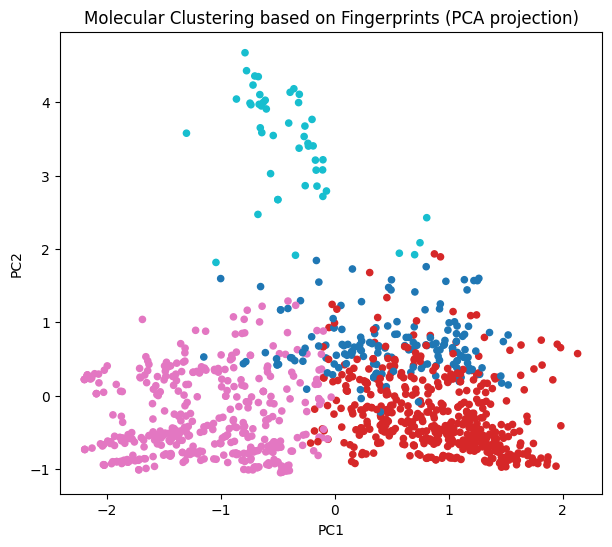

In [18]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

fps = df["morganfp"].to_list()

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(fps)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(fps)
df["cluster"] = clusters

# Visualize clusters
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap="tab10", s=20)
plt.title("Molecular Clustering based on Fingerprints (PCA projection)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

In [19]:
print(df.groupby("cluster")["logS"].mean())

cluster
0   -3.678024
1   -3.569267
2   -2.120079
3   -4.447604
Name: logS, dtype: float64


In [20]:
df["has_aromat"] = df["SMILES"].apply(lambda s: Chem.MolFromSmiles(s).HasSubstructMatch(Chem.MolFromSmarts("a")))
pd.crosstab(df["cluster"], df["has_aromat"])

has_aromat,False,True
cluster,,
0,4,160
1,17,470
2,405,40
3,43,5


### Part 6: Substructure Search via SMARTS

Search for specific functional groups or chemical motifs within the dataset using SMARTS (SMiles ARbitrary Target Specification): e.g. alcohol = "[OX2H]", carboxylic acid = "C(=O)[OH]", aromatic compounds = "a", amines = "[NX3;H2,H1;!$(NC=O)]"

See here for a more detailed list of SMARTS: https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html 

Tasks:
- Count how many molecules contain each functional group (method: Mol.HasSubstructMatch(SMARTS)).
- Compare average solubility for molecules with vs. without each substructure.
- Visualize with a bar plot.

In [30]:
from rdkit import Chem

patterns = {
    "Hydroxyl": Chem.MolFromSmarts("[OX2H]"),
    "Amines": Chem.MolFromSmarts("[NX3;H2,H1;!$(NC=O)]"),
    "Aromatic Alcohols": Chem.MolFromSmarts("[OH][c]"),
    "Carboxlic acid": Chem.MolFromSmarts("C(=O)[OH]"),
}

def has_substructure(smiles, pattern):
    mol= Chem.MolFromSmiles(smiles)
    return mol.HasSubstructMatch(pattern)

for name, pattern in patterns.items():
    df[name] = df["SMILES"].apply(lambda s: has_substructure(s, pattern))

df.head()

,Compound ID,logS,SMILES,MolWt,TPSA,BalabanJ,NumHAcceptors,MolLogP,morganfp,similarity,cluster,has_aromat,Amines,Aromatic Alcohols,Carboxlic acid,Hydroxyl
0,"1,1,1,2-Tetrachloroethane",-2.18,ClCC(Cl)(Cl)Cl,167.850,0.0,3.168490,0,2.5954,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000,2,False,False,False,False,False
1,"1,1,1-Trichloroethane",-2.00,CC(Cl)(Cl)Cl,133.405,0.0,3.023716,0,2.3765,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.033333,2,False,False,False,False,False
2,"1,1,2,2-Tetrachloroethane",-1.74,ClC(Cl)C(Cl)Cl,167.850,0.0,2.993497,0,2.5938,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000,2,False,False,False,False,False
3,"1,1,2-Trichloroethane",-1.48,ClCC(Cl)Cl,133.405,0.0,2.539539,0,2.0289,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000,2,False,False,False,False,False
4,"1,1,2-Trichlorotrifluoroethane",-3.04,FC(F)(Cl)C(F)(Cl)Cl,187.375,0.0,4.020392,0,2.9189,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000,2,False,False,False,False,False


In [29]:
df[list(patterns.keys())].sum()

Hydroxyl             245
Amines                98
Aromatic Alcohols     92
Carboxlic acid         0
dtype: int64

In [31]:
for name in patterns.keys():
    print(df.groupby(name)["logS"].mean())

Hydroxyl
False   -3.262195
True    -2.308718
Name: logS, dtype: float64
Amines
False   -3.090373
True    -2.712439
Name: logS, dtype: float64
Aromatic Alcohols
False   -3.116432
True    -2.389815
Name: logS, dtype: float64
Carboxlic acid
False   -3.057997
Name: logS, dtype: float64


No Carboxlic acid in dataset


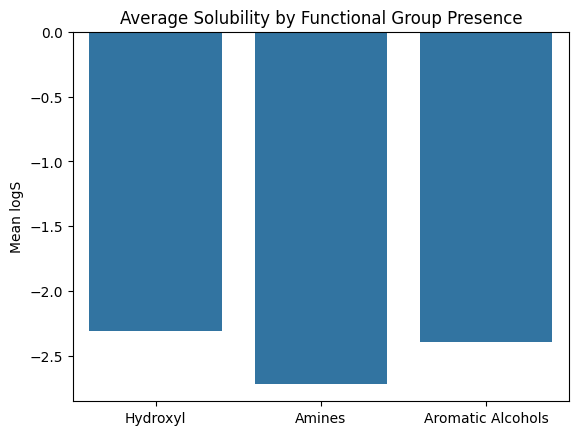

In [32]:
import seaborn as sns
means = {}

for name in patterns.keys():
    mean_series = df.groupby(name)["logS"].mean()
    if len(mean_series) > 1:
        val = mean_series.iloc[1]
        means[name] = val
    else:
        print(f"No {name} in dataset")

sns.barplot(x=list(means.keys()), y=list(means.values()))
plt.title("Average Solubility by Functional Group Presence")
plt.ylabel("Mean logS")
plt.show()